<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Bar_Magnet_Field_Lines_MagPyLib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:396: MagpylibDeprecationWarning: Cuboid(id=140463624196560) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()


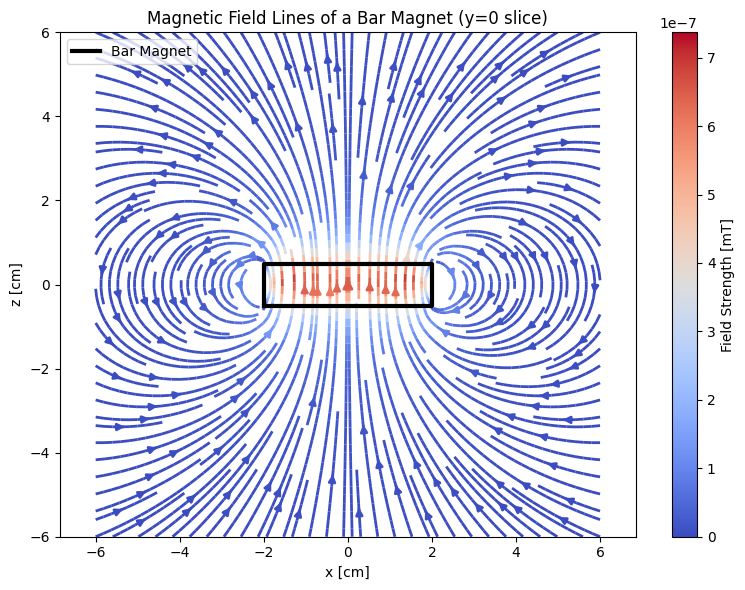

In [1]:
# Install Magpylib in Google Colab if needed
!pip install magpylib --quiet

import numpy as np
import matplotlib.pyplot as plt
from magpylib import Collection
from magpylib.magnet import Cuboid

# 1. Define the bar magnet: (length=4, width=1, height=1) in centimeters, magnetized along z-axis
magnet = Cuboid(
    magnetization=(0, 0, 1),  # [mT] Magnetized along the z-axis
    dimension=(4, 1, 1)       # [cm] Length (x), Width (y), Height (z)
)

# 2. Generate a grid of points (2D slice for clear plotting)
x = np.linspace(-6, 6, 25)
z = np.linspace(-6, 6, 25)
X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)  # y=0 plane

positions = np.stack([X, Y, Z], axis=-1).reshape(-1,3)

# 3. Compute the magnetic field at each point
B = magnet.getB(positions)  # mT
Bx = B[:,0].reshape(X.shape)
Bz = B[:,2].reshape(Z.shape)

# 4. Plot the vector field with streamlines
plt.figure(figsize=(8,6))
plt.title('Magnetic Field Lines of a Bar Magnet (y=0 slice)')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.streamplot(
    X, Z, Bx, Bz,
    color=np.hypot(Bx, Bz),
    linewidth=2, cmap='coolwarm', density=2
)
# Draw the outline of the magnet for reference
magnet_outline = [
    [-2, -0.5], [2, -0.5], [2, 0.5], [-2, 0.5], [-2, -0.5]
]
magnet_outline = np.array(magnet_outline)
plt.plot(magnet_outline[:,0], magnet_outline[:,1], 'k-', lw=3, label='Bar Magnet')

plt.legend()
plt.colorbar(label='Field Strength [mT]')
plt.axis('equal')
plt.tight_layout()
plt.show()


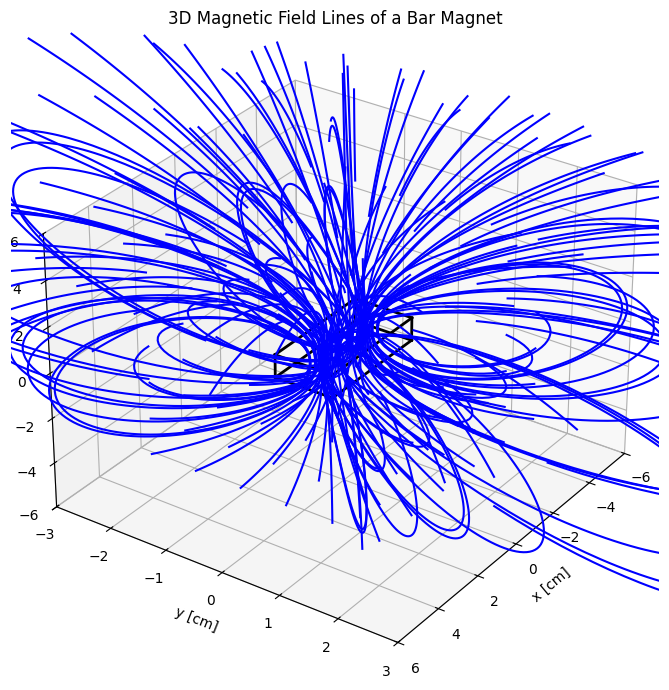

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cuboid

from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# 1. Bar magnet definition
magnet = Cuboid(
    magnetization=(0, 0, 1e5),   # [A/m] in Magpylib v5+
    dimension=(4, 1, 1)          # [cm]
)

# 2. Define seed points for starting field lines (in a grid around the magnet)
n_per_axis = 6
x_seeds = np.linspace(-4, 4, n_per_axis)
y_seeds = np.linspace(-2, 2, n_per_axis)
z_seeds = np.linspace(-4, 4, n_per_axis)
seed_points = []
for x in x_seeds:
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in z_seeds:
            seed_points.append([x, y, z])
    for y in y_seeds:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
    for y in [y_seeds[0], y_seeds[-1]]:
        for z in [z_seeds[0], z_seeds[-1]]:
            seed_points.append([x, y, z])
seed_points = np.unique(seed_points, axis=0)  # Remove duplicates

# 3. Field line tracing function
def trace_field_line(start, magnet, step=0.1, n_steps=200):
    points = [np.array(start)]
    for _ in range(n_steps):
        pos = points[-1]
        B = magnet.getB(pos)
        norm = np.linalg.norm(B)
        if norm < 1e-5:
            break
        direction = B / norm
        next_pos = pos + direction * step
        points.append(next_pos)
        # Stop if we move too far away
        if np.linalg.norm(next_pos) > 10:
            break
    return np.array(points)

# 4. Plot field lines in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Magnetic Field Lines of a Bar Magnet')

# Draw magnet as a black cuboid
lx, ly, lz = 4, 1, 1
magnet_center = [0, 0, 0]
rx = lx / 2
ry = ly / 2
rz = lz / 2
for s, e in [
    [[-rx,-ry,-rz],[rx,-ry,-rz]], [[rx,-ry,-rz],[rx,ry,-rz]], [[rx,ry,-rz],[-rx,ry,-rz]], [[-rx,ry,-rz],[-rx,-ry,-rz]],
    [[-rx,-ry,rz],[rx,-ry,rz]], [[rx,-ry,rz],[rx,ry,rz]], [[rx,ry,rz],[-rx,ry,rz]], [[-rx,ry,rz],[-rx,-ry,rz]],
    [[-rx,-ry,-rz],[-rx,-ry,rz]], [[rx,-ry,-rz],[rx,-ry,rz]], [[rx,ry,-rz],[rx,ry,rz]], [[-rx,ry,-rz],[-rx,ry,rz]]
]:
    ax.plot(*zip(s, e), color='k', linewidth=2)

# Trace and plot field lines
for seed in seed_points:
    path = trace_field_line(seed, magnet, step=0.15, n_steps=160)
    ax.plot(path[:,0], path[:,1], path[:,2], lw=1.5, color='blue')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.set_xlim(-6, 6)
ax.set_ylim(-3, 3)
ax.set_zlim(-6, 6)
ax.view_init(30, 35)
plt.tight_layout()
plt.show()